In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

import scipy as scipy
from scipy.spatial.distance import euclidean

#from tqdm import tqdm_notebook
import time

from tqdm import tqdm

In [2]:
class Diffusion:
    # сетки
    def __init__(self):
        return
        
    def solve(self, Dp):
        L = 1
        Nx = 11
        self.Nx = Nx
        Nt = 1001
        self.Nt = Nt
        T_end = 100
        self.x = np.linspace(0,L,Nx)
        
        left_cond = 1 # слева concentration
        right_cond = -1 # справа значение концентрации
        CTR_0 = -10
        
        # parameters
        CTR = np.zeros((Nx, Nt))
        D = np.zeros((Nx,Nt))
        for j in range(Nt):
            D[:,j] = Dp[j*Nx:(j+1)*Nx]
        

        CTR[:,0] = CTR_0
        CTR[0,:] = left_cond
        CTR[Nx-1,0] = right_cond
        
        
        A = np.zeros((Nx,Nx, Nt))
        b = np.zeros((Nx, Nt))
        b1 = np.zeros((Nx,Nx))
        
        dd = (L / (Nx-1))**2 / (T_end / (Nt - 1))
        
        
        for j in range(Nt-1):
        
            A[0,0,j] = 1
            A[Nx-1,Nx-1,j] = 1
            b[0,j] = CTR[0,j]
            b[Nx-1,j] = CTR[Nx-1,j]
            b1[0,0] = 1
            b1[Nx-1,Nx-1] = 1
            
            for i in range(1,Nx-1):
                A[i,i,j] = - (D[i,j] + D[i+1,j] + dd)
                A[i,i+1,j] = D[i+1,j]
                b[i,j] = - dd * CTR[i,j]
                b1[i,i] = - dd
            for i in range(0,Nx-2):
                A[i+1,i,j] = D[i,j]
            
            CTR[:,j+1] = np.linalg.solve(A[:,:,j], b[:,j])
           
        
        CTR_f = np.zeros(Nx*Nt)
        for j in range(Nt):
            CTR_f[j*Nx:(j+1)*Nx] = CTR[:,j]
        
        self.solution = CTR_f
        return CTR_f, A, b, b1
    
    def cf_grad(self, D):
        Nx = self.Nx
        Nt = self.Nt
        C_fix = self.C_fix1

        lam = np.zeros((Nx,Nt))
        CTR_f, A, b, b1 = self.solve(D) 
        
        CTR = np.zeros((Nx, Nt))
        for j in range(Nt):
            CTR[:,j] = CTR_f[j*Nx:(j+1)*Nx]

        lam[:,Nt-1] = -(CTR[:,Nt-1] - C_fix[:,Nt-1]).T @ np.linalg.inv(A[:,:,Nt-2]) # Ваня ищет оператор

        for j in range(Nt-2,0,-1):
            lam[:,j] = - np.linalg.inv(A[:,:,j-1]) @ ((CTR[:,j] - C_fix[:,j]) + lam[:,j+1] @ (-b1))

        
        gu = np.zeros((Nx,Nx,Nt))
        
        for j in range(Nt-1):
            gu[0,0,j] = -CTR[0,j+1]
            gu[Nx-1,Nx-1,j] = -CTR[Nx-1,j+1]
            for i in range(1,Nx-1):
                gu[i,i,j] = CTR[i-1,j+1] - CTR[i,j+1]
                gu[i,i+1,j] = CTR[i+1,j+1] - CTR[i,j+1]
        
                
        grad = np.zeros(Nx * Nt)
        for j in range(Nt-1):
            grad[j*Nx:(j+1)*Nx] = lam[:,j+1] @ gu[:,:,j]
        
        grad = grad / np.linalg.norm(grad)
        return grad
            
            
    
    def cost_function(self, D):
        sol, _,_,_ = self.solve(D)
        val = (sol - self.C_fix).T @ (sol - self.C_fix) 
        
        return val / 2
    
    
    def initialize(self, C_fix):
        
        self.C_fix = C_fix
        C = np.zeros((self.Nx, self.Nt))
        for j in range(self.Nt):
            C[:,j] = C_fix[j*self.Nx:(j+1)*self.Nx]
        
        self.C_fix1 = C
    
    def plot(self, timesteps):
        [plt.plot(self.x, self.solution[tp*self.Nx: (tp+1)*self.Nx], ) for tp in timesteps]
        plt.show()

In [3]:
slvr = Diffusion()
x=np.linspace(0,1,11)
Dp =np.sin(x)
D = np.zeros(11*1001)
for j in range(1001):
    D[j*11:(j+1)*11] = Dp
%time slvr1 = Diffusion()

Wall time: 0 ns


In [4]:
%time C1, A, b, b1 = slvr.solve(D)
%time Cfix, A, b, b1 = slvr1.solve(D)

Wall time: 73.8 ms
Wall time: 39.3 ms


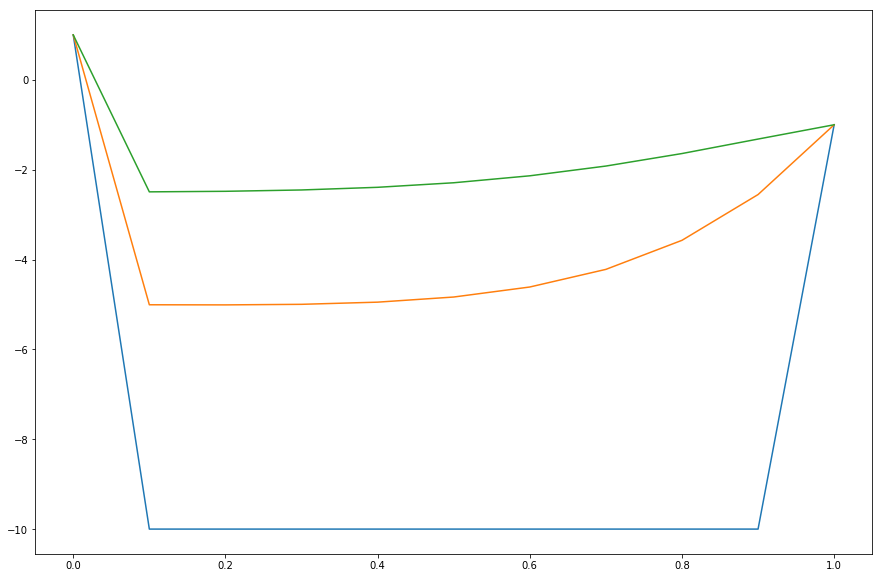

In [62]:
plt.figure()
slvr1.plot([0, 1, 2])

In [6]:
slvr.initialize(Cfix)

In [7]:
jaco = slvr.cf_grad(D+1)

In [8]:
jaco

array([ 0.02661461,  0.43267952,  0.09758116, ...,  0.        ,
        0.        ,  0.        ])

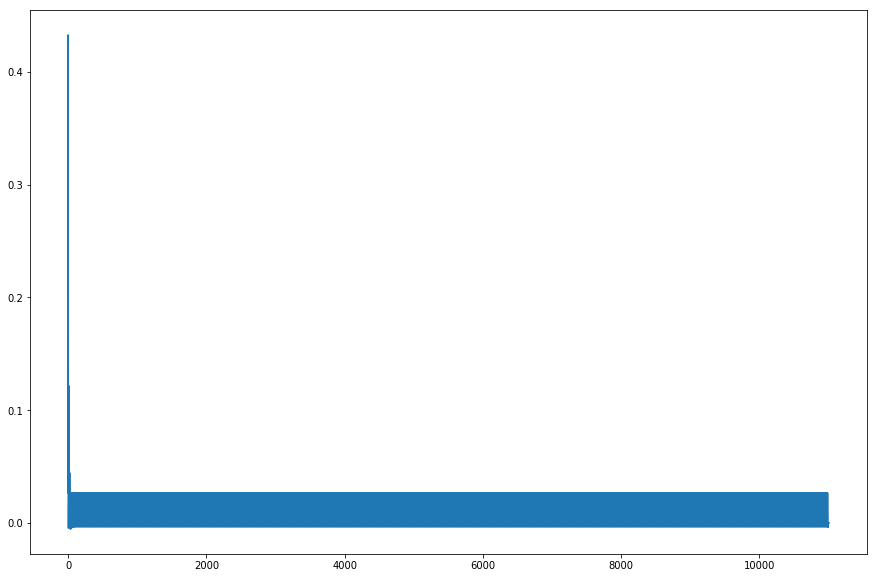

In [10]:
_ = plt.plot(jaco)

In [11]:
bb = np.random.random(size=len(D))

x0 = D + bb - D.mean()
#x0 = np.linspace(0,100,len(D))

In [12]:
len(x0)

11011

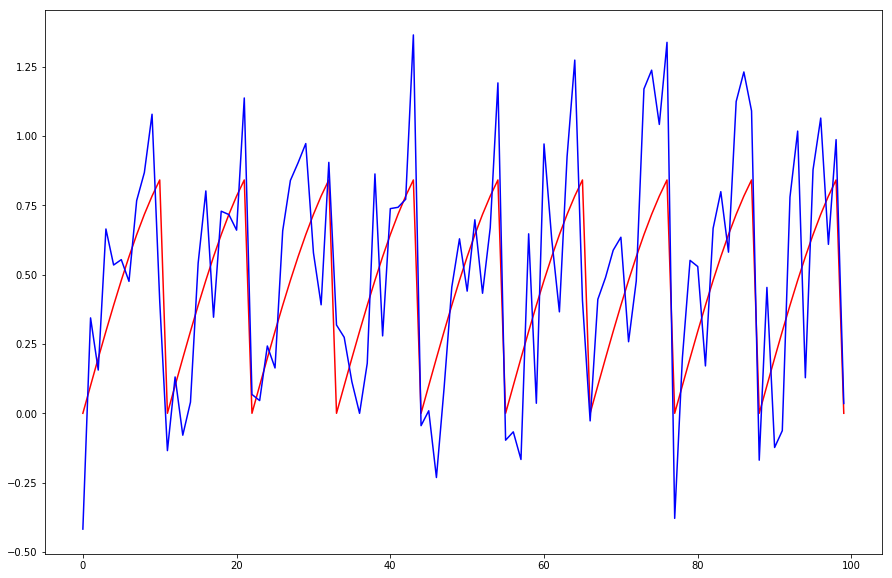

In [13]:
plt.figure()
plt.plot(D[:100], 'r')
plt.plot(x0[:100], 'b')

In [61]:
%time slvr.cf_grad(D+1)

Wall time: 95.7 ms


array([ 0.02661461,  0.43267952,  0.09758116, ...,  0.        ,
        0.        ,  0.        ])

In [14]:
slvr.cost_function(D+1)

397.42344831206788

In [42]:
def GradientDescent(f, gradf, x0,  num_iter, eps, **kwargs):
    x_prev = x0.copy()
    
    iteration = 0

    less = False
    alpha = 10
    x_new = np.zeros(len(x_prev))
    sk_prev = - gradf(x_prev)
    while True:
        
        if less == True:
            alpha *= 0.5
            #sk_prev = sk_prev
            
            
        #else:
        #    sk_prev = - gradf(x_prev)

        x_new = x_prev + alpha * sk_prev
        
        
        
        
        gain = (x_new - x_prev) / x_prev
        if gain.T @ gain < eps:
            print(f"gain less that {eps}")
            break
        
        gradient = gradf(x_prev)
        g_new = gradf(x_new)
        #print()
        pr = (g_new.T @ (g_new - gradient)) / (gradient.T @ gradient)
        #fr = (g_new.T @ g_new) / (gradient.T @ gradient)
        w = np.maximum(0, pr)
        #w = fr    
        sk_prev = - g_new + sk_prev * w
        #sk_prev = sk_prev * w
        
        if (f(x_new) - f(x_prev)) < 0:
            
            x_prev = x_new
             
            
            alpha = 10
            less = False
            
        else:
            less = True
            
            
        print(f"CFV = {f(x_prev)}, less = {less}, alpha = {alpha}, GS = {np.sign(gradient.T @ g_new)}")
        
        iteration += 1

        if iteration >= num_iter:
            break
        
    res = x_prev
    return res

In [59]:
%time res = GradientDescent(f = slvr.cost_function, x0=x0, gradf=slvr.cf_grad, num_iter=100, eps=1e-8)

CFV = 23406.785445929523, less = False, alpha = 10, GS = 1.0
CFV = 2689.3826699525816, less = False, alpha = 10, GS = 1.0
CFV = 2689.3826699525816, less = True, alpha = 10, GS = -1.0
CFV = 991.883856990332, less = False, alpha = 10, GS = 1.0
CFV = 557.3743116850015, less = False, alpha = 10, GS = 1.0
CFV = 553.4005187109, less = False, alpha = 10, GS = -1.0
CFV = 553.4005187109, less = True, alpha = 10, GS = 1.0
CFV = 553.4005187109, less = True, alpha = 5.0, GS = 1.0
CFV = 553.4005187109, less = True, alpha = 2.5, GS = 1.0
CFV = 359.8542226368045, less = False, alpha = 10, GS = 1.0
CFV = 359.8542226368045, less = True, alpha = 10, GS = -1.0
CFV = 359.8542226368045, less = True, alpha = 5.0, GS = 1.0
CFV = 359.8542226368045, less = True, alpha = 2.5, GS = 1.0
CFV = 354.52188998283987, less = False, alpha = 10, GS = 1.0
CFV = 354.52188998283987, less = True, alpha = 10, GS = -1.0
CFV = 283.98300585261944, less = False, alpha = 10, GS = 1.0
CFV = 283.98300585261944, less = True, alpha = 

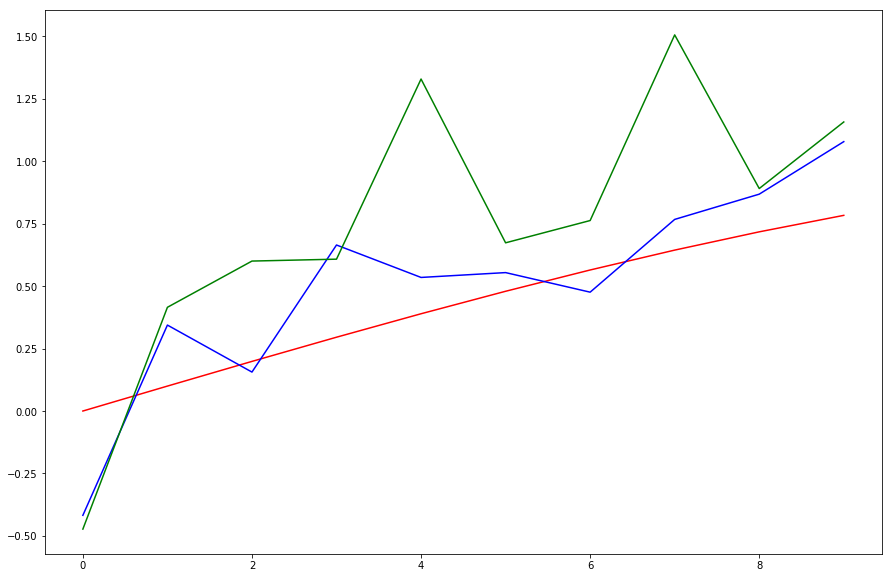

In [60]:
plt.figure()
plt.plot(D[:10], 'r')
plt.plot(x0[:10], 'b')
plt.plot(res[:10], 'g')

In [48]:
def AGD(f, gradf, x0,  num_iter, eps, **kwargs):
    x = x0.copy()
    y_prev = x
    lam_prev = 0
    alpha = 1
    iteration = 0
    
    less = False
    sk_prev = - gradf(x)
    while True:
        
        lam_new = (1 + np.sqrt(1 + 4 * lam_prev**2)) / 2
        gamma = (1 - lam_prev) / lam_new
        #print(f"gamma = {gamma}")
        lam_prev = lam_new
        
        
        if less == True:
            alpha *= 0.5
            
        y_new = x - alpha * gradf(x)
        
        #g_prev = gradf(y_prev)
        #g_new = gradf(y_new)
        #print()
        #pr = (g_new.T @ (g_new - g_prev)) / (g_prev.T @ g_prev)
        #fr = (g_new.T @ g_new) / (gradient.T @ gradient)
        #w = np.maximum(0, pr)
        #w = fr    
        #sk_prev = - g_new + sk_prev * w
        #sk_prev = sk_prev * w
        
        
        x = (1 - gamma) * y_new + gamma * y_prev
        y_prev = y_new
        
        gain = (y_new - y_prev) / y_prev
        #if gain.T @ gain < eps:
        #    print(f"gain less that {eps}")
        #    break
        
        if f(y_prev) > f(y_new):
            less = False
            alpha = 1
        else:
            less = True
        print(f"CFV = {f(y_prev)}")
        
        iteration += 1
        if iteration >= num_iter:
            break
        
    return x
        
        

In [50]:
%time res = AGD(f = slvr.cost_function, x0=x0, gradf=slvr.cf_grad, num_iter=100, eps=1e-8)

CFV = 36313.717431939556
CFV = 37555.37316844968
CFV = 6180.850932346935
CFV = 6352.444174367938
CFV = 2914.67058643394
CFV = 2532.313553277302
CFV = 2465.5939492574025
CFV = 2371.882179601889
CFV = 2150.849908775378
CFV = 2046.767652768037
CFV = 1991.3361200595114
CFV = 1954.917447410873
CFV = 1928.5766264881895
CFV = 1908.5874367107162
CFV = 1892.9595680112338
CFV = 1880.472840753779
CFV = 1870.3205366080565
CFV = 1861.9444044084948
CFV = 1854.9458441615607
CFV = 1849.0333361922692
CFV = 1843.9894034759136
CFV = 1839.648998762715
CFV = 1835.8849454740207
CFV = 1832.5979003387292
CFV = 1829.7092968840695
CFV = 1827.156298482169
CFV = 1824.8881321484002
CFV = 1822.8633871500301
CFV = 1821.047998182482
CFV = 1819.4137211849998
CFV = 1817.936968371494
CFV = 1816.5979084262688
CFV = 1815.3797647007748
CFV = 1814.2682628573343
CFV = 1813.2511924521982
CFV = 1812.3180562076786
CFV = 1811.4597873675214
CFV = 1810.6685203507575
CFV = 1809.9374034534612
CFV = 1809.260444964026
CFV = 1808.63238

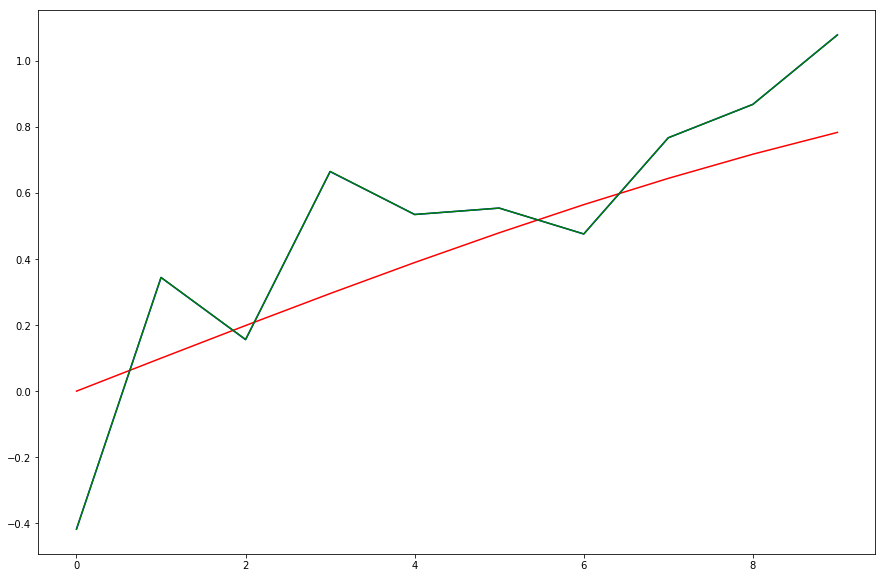

In [56]:
plt.figure()
plt.plot(D[:10], 'r')
plt.plot(x0[:10], 'b')
plt.plot(res[:10], 'g')